Dans ce Notebook, nous allons étudier comment utiliser un modèle optimisé avec TensorRT à l'aide de Cuda.



In [3]:
import tensorflow as tf
import numpy as np
import cv2
import os
import shutil

from tensorflow import keras
from matplotlib import pyplot as plt

### Chargement du moteur (engine)

On commence par créer une instance de logger qui va nous permettre d'afficher les informations pendant l'utilisation du moteur.

In [4]:
import tensorrt as trt

# Construction de la class du logger
class MyLogger(trt.ILogger):
    def __init__(self):
        trt.ILogger.__init__(self)

    def log(self, severity, msg):
        print("%s : %s" %(severity,msg))
        pass

 Ensuite, on créé un ``runtime`` (environnement de travail) pour notre modèle puis on charge le moteur à l'aide de la fonction ``deserialize_cuda_engine`` que nous porpose ce runtime.

In [5]:
import pycuda.driver as cuda
import pycuda.autoinit

PRECISION = trt.int32

logger = MyLogger()
runtime = trt.Runtime(logger)
trt.init_libnvinfer_plugins(logger, namespace="")

with open("model_jetson.engine", "rb") as f:
    engine = runtime.deserialize_cuda_engine(f.read())

Severity.INFO : [MemUsageChange] Init CUDA: CPU +225, GPU +0, now: CPU 320, GPU 2675 (MiB)
Severity.VERBOSE : Registered plugin creator - ::BatchTilePlugin_TRT version 1
Severity.VERBOSE : Registered plugin creator - ::BatchedNMS_TRT version 1
Severity.VERBOSE : Registered plugin creator - ::BatchedNMSDynamic_TRT version 1
Severity.VERBOSE : Registered plugin creator - ::CoordConvAC version 1
Severity.VERBOSE : Registered plugin creator - ::CropAndResize version 1
Severity.VERBOSE : Registered plugin creator - ::CropAndResizeDynamic version 1
Severity.VERBOSE : Registered plugin creator - ::DecodeBbox3DPlugin version 1
Severity.VERBOSE : Registered plugin creator - ::DetectionLayer_TRT version 1
Severity.VERBOSE : Registered plugin creator - ::EfficientNMS_TRT version 1
Severity.VERBOSE : Registered plugin creator - ::EfficientNMS_ONNX_TRT version 1
Severity.VERBOSE : Registered plugin creator - ::EfficientNMS_Explicit_TF_TRT version 1
Severity.VERBOSE : Registered plugin creator - ::E

 ### Création du contexte

Ensuite, il faut créer un contexte nécessaire pour lancer le modèle. Ce contexte va allouer une certaine quantité de mémoire afin de pouvoir travailler avec notre mmoteur.

In [6]:
context = engine.create_execution_context()

Severity.VERBOSE : Using cublas as a tactic source
Severity.INFO : [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +0, now: CPU 721, GPU 3294 (MiB)
Severity.VERBOSE : Using cuDNN as a tactic source
Severity.INFO : [MemUsageChange] Init cuDNN: CPU +0, GPU +0, now: CPU 721, GPU 3294 (MiB)
Severity.VERBOSE : Total per-runner device persistent memory is 13678592
Severity.VERBOSE : Total per-runner host persistent memory is 157056
Severity.VERBOSE : Allocated activation device memory of size 18387456
Severity.INFO : [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +30, now: CPU 0, GPU 44 (MiB)


### Allocation de l'espace mémoire hôte et GPU

Nous allons devoir allouer de l'espace en mémoire sur **l'hote** et sur le **GPU** pour réaliser des transferts de données entre eux.
Commençons par regarder combien de mémoire nous avons en GPU :

In [7]:
cuda.mem_get_info()

(648134656, 4148043776)

Pour transférer des données entre l'hôte et le GPU, celles-ci doivent être transférées depuis un espace mémoire paginé vérrouillé de l'hôte. On va donc devoir réserver un espace mémoire sur l'hôte et le vérrouiller (cet espace ne pourra pas servir à autre chose et donc ne pourra pas être utlisé par un autre processus).

Les étapes à suivre pour utliser notre moteur sont les suivantes :
- Réserver un espace mémoire vérrouillé sur l'hote pour y placer l'entrée (**input_host_mem**) et la sortie du modèle (**output_host_mem**)
- Réserver un espace mémoire dans le GPU pour y placer ces mêmes informations (**input_device_mem** et **output_device_mem**)
- Placer les données d'entrées du modèle (notre image) dans l'espace mémoire hôte vérrouillé qu'on a pris soin de réserver au préalable (**input_host_mem**)
- Transférer le contenu de cet espace mémoire vers la mémoire du GPU (**input_device_mem**)
- Lancer les calculs avec le modèle TensorRT qu'on a défini ; les résultats seront écrits dans la mémoire du GPU (**output_device_mem**)
- Transférer les résultats de la mémoire GPU (**output_device_mem**) vers la mémoire vérrouillées de l'hote (**output_host_mem**)

On peut trouver des informations sur le format des tenseurs en entrée et en sortie de notre moteur :

In [8]:
for binding in engine:
    print(engine.get_binding_shape(binding))
    print(trt.nptype(engine.get_binding_dtype(binding)))

(1, 256, 256, 3)
<class 'numpy.int32'>
(1, 1, 17, 3)
<class 'numpy.float32'>


On va donc utiliser ces informations pour allouer les espaces en mémoire hôte et GPU :

In [9]:
# Réservation de la mémoire pour l'entrée
size_input = trt.volume(engine.get_binding_shape(0))* engine.max_batch_size
input_host_mem = cuda.pagelocked_empty(size_input, trt.nptype(PRECISION))
input_device_mem = cuda.mem_alloc(input_host_mem.nbytes)

In [10]:
# Réservation de la mémoire pour les sorties
output_device_mem = [];
format_sorties = [];
types_sorties = [];

for i in range(engine.num_bindings):
    if not engine.binding_is_input(i):
        size_output = trt.volume(engine.get_binding_shape(i))* engine.max_batch_size
        output_host_mem = cuda.pagelocked_empty(size_output, trt.nptype(PRECISION))
        output_device_mem.append(cuda.mem_alloc(output_host_mem.nbytes))
        format_sorties.append(engine.get_binding_shape(i))
        types_sorties.append(trt.nptype(engine.get_binding_dtype(i)))

Il faut maintenant récupérer les adresses mémoires GPU. Ces adresses seront utiles au contexte de TensorRT précédemment ouvert pour pouvoir exécuter le modèle.

In [11]:
# Récupère les adresses en GPU des buffers entrées / sorties
binding_entree = int(input_device_mem)

binding_sorties = []
for output_ in output_device_mem:
    binding_sorties.append(int(output_))

### Exécution d'une prédiction

On commence par récupérer une image du dataset :

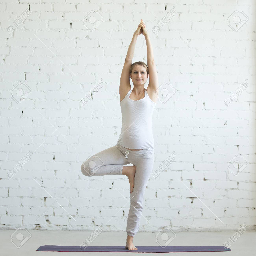

In [12]:
image = tf.keras.preprocessing.image.load_img("Yoga.jpg",target_size=(256, 256))
image

Puis on convertit cette image en tenseur :

On copie maintenant ce tenseur dans l'espace mémoire d'entrée de l'hôte. Le tenseur est applati à l'aide de la fonction ``ravel()``:

In [13]:
image = np.expand_dims(image,axis=0)                          # (1,256,256,3)
image = image.astype(np.int32)
np.copyto(input_host_mem,image.ravel())

In [14]:
image

array([[[[212, 214, 209],
         [212, 214, 209],
         [213, 215, 210],
         ...,
         [221, 222, 217],
         [216, 217, 209],
         [212, 212, 204]],

        [[212, 214, 209],
         [212, 214, 209],
         [213, 215, 210],
         ...,
         [221, 222, 217],
         [216, 217, 209],
         [212, 212, 204]],

        [[206, 208, 203],
         [219, 221, 216],
         [201, 203, 198],
         ...,
         [221, 222, 217],
         [216, 217, 209],
         [210, 210, 202]],

        ...,

        [[191, 193, 188],
         [191, 193, 188],
         [191, 193, 188],
         ...,
         [195, 197, 192],
         [195, 197, 192],
         [193, 195, 190]],

        [[189, 191, 186],
         [191, 193, 188],
         [190, 192, 187],
         ...,
         [191, 193, 188],
         [192, 194, 189],
         [195, 197, 192]],

        [[189, 190, 185],
         [190, 191, 186],
         [191, 192, 187],
         ...,
         [194, 195, 190],
        

Transfert les données de l'image vers la mémoire GPU (transfert Host => Device) :

In [15]:
cuda.memcpy_htod(input_device_mem, input_host_mem)

Exécution du modèle :

In [16]:
bindings = [binding_entree, binding_sorties[0]]

In [17]:
bindings

[64487817216, 64488603648]

In [18]:
context.execute_v2(bindings=bindings)

True

On transfert le résultat stocké en mémoire GPU vers la mémoire destination de l'hôte :

In [19]:
output_device_mem

In [20]:
output_host_mem = []
for i in range(len(output_device_mem)):
    output_host_mem.append(np.zeros(format_sorties[i],types_sorties[i]))

for i in range(len(output_host_mem)):
    cuda.memcpy_dtoh(output_host_mem[i], output_device_mem[i])
output_host_mem

[array([[[[0.30270386, 0.54341125, 0.6535693 ],
          [0.2872734 , 0.5587616 , 0.7017131 ],
          [0.28838348, 0.5281067 , 0.6502452 ],
          [0.2967987 , 0.5781555 , 0.5855752 ],
          [0.30223083, 0.5124359 , 0.7889086 ],
          [0.36525726, 0.5957489 , 0.61555016],
          [0.36132812, 0.4871254 , 0.7659437 ],
          [0.23402405, 0.5835953 , 0.6757646 ],
          [0.23616028, 0.49736023, 0.7947038 ],
          [0.12838745, 0.5739441 , 0.7300975 ],
          [0.1324768 , 0.5308914 , 0.53704137],
          [0.5859451 , 0.5652504 , 0.86083776],
          [0.5768585 , 0.47817993, 0.8161134 ],
          [0.779129  , 0.53134155, 0.8100285 ],
          [0.6556854 , 0.33646774, 0.77696157],
          [0.93865967, 0.5089264 , 0.7981868 ],
          [0.66082764, 0.49780273, 0.7595823 ]]]], dtype=float32)]

## Visualisation du résultat

**Outputs**

A float32 tensor of shape [1, 1, 17, 3].

* The first two channels of the last dimension represents the yx coordinates (normalized to image frame, i.e. range in [0.0, 1.0]) of the 17 keypoints:
  * 0: nose,
  * 1, 2 : left eye, right eye,
  * 3, 4 : left ear, right ear
  * 5, 6 : left shoulder, right shoulder
  * 7, 8 : left elbow, right elbow
  * 9, 10 : left wrist, right wrist
  * 11, 12 : left hip, right hip
  * 13, 14 : left knee, right knee
  * 15, 16 : left ankle, right ankle

* The third channel of the last dimension represents the prediction confidence scores of each keypoint, also in the range [0.0, 1.0].

<center><img src="https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Olympidades2024/InfoTenseur.jpg?raw=true" width=700></center>

In [21]:
# Par exemple, pour obtenir la coordonnée X de l'oeuil gauche :
output_host_mem[0][0][0][1][0]

0.2872734

In [22]:
# Par exemple, pour obtenir la coordonnée Y de l'oeuil gauche :
output_host_mem[0][0][0][1][1]

0.5587616

In [23]:
# Par exemple, pour obtenir la coordonnée X du nez :
output_host_mem[0][0][0][0][0]

0.30270386

In [24]:
# Par exemple, pour obtenir la coordonnée Y du nez :
output_host_mem[0][0][0][0][1]

0.54341125

In [25]:
output_host_mem[0][0][0][:][:]

array([[0.30270386, 0.54341125, 0.6535693 ],
       [0.2872734 , 0.5587616 , 0.7017131 ],
       [0.28838348, 0.5281067 , 0.6502452 ],
       [0.2967987 , 0.5781555 , 0.5855752 ],
       [0.30223083, 0.5124359 , 0.7889086 ],
       [0.36525726, 0.5957489 , 0.61555016],
       [0.36132812, 0.4871254 , 0.7659437 ],
       [0.23402405, 0.5835953 , 0.6757646 ],
       [0.23616028, 0.49736023, 0.7947038 ],
       [0.12838745, 0.5739441 , 0.7300975 ],
       [0.1324768 , 0.5308914 , 0.53704137],
       [0.5859451 , 0.5652504 , 0.86083776],
       [0.5768585 , 0.47817993, 0.8161134 ],
       [0.779129  , 0.53134155, 0.8100285 ],
       [0.6556854 , 0.33646774, 0.77696157],
       [0.93865967, 0.5089264 , 0.7981868 ],
       [0.66082764, 0.49780273, 0.7595823 ]], dtype=float32)

In [26]:
toto =output_host_mem[0][0][0][:][:]
toto[0]

array([0.30270386, 0.54341125, 0.6535693 ], dtype=float32)

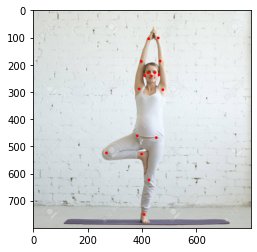

In [27]:
import cv2

def draw_points(img_cv2, coordonneesXY, line_width=1):
    width, height = (800,800)

    # Place les points
    for point in coordonneesXY:
      pt_Y = point[0]
      pt_X = point[1]

      # Calcule la position du point sur l'image
      pt_image_X = pt_X * width
      pt_image_Y = pt_Y * height

      # Affiche le point sur l'image
      img = cv2.circle(img_cv2, (int(pt_image_X),int(pt_image_Y)), radius=5, color=(0, 0, 255), thickness=-1)

    return img

image = cv2.imread("Yoga.jpg")
image = cv2.resize(image,(int(800),int(800)),3)

draw_image = draw_points(image, output_host_mem[0][0][0][:][:])
draw_image = cv2.cvtColor(draw_image, cv2.COLOR_BGR2RGB)
plt.imshow(draw_image)

In [ ]:
import cv2

def draw_lines(img_cv2, coordonneesXY, line_width=1):
    width, height = (600,600)

    nez = [int(coordonneesXY[0][1]*width),int(coordonneesXY[0][0]*height)]
    oeuil_gauche = [int(coordonneesXY[1][1]*width),int(coordonneesXY[1][0]*height)]
    oeuil_droit = [int(coordonneesXY[2][1]*width),int(coordonneesXY[2][0]*height)]
    oreille_gauche = [int(coordonneesXY[3][1]*width),int(coordonneesXY[3][0]*height)]
    oreille_droite = [int(coordonneesXY[4][1]*width),int(coordonneesXY[4][0]*height)]
    epaule_gauche = [int(coordonneesXY[5][1]*width),int(coordonneesXY[5][0]*height)]
    epaule_droite = [int(coordonneesXY[6][1]*width),int(coordonneesXY[6][0]*height)]
    coude_gauche = [int(coordonneesXY[7][1]*width),int(coordonneesXY[7][0]*height)]
    coude_droite = [int(coordonneesXY[8][1]*width),int(coordonneesXY[8][0]*height)]
    poignet_gauche = [int(coordonneesXY[9][1]*width),int(coordonneesXY[9][0]*height)]
    poignet_droite = [int(coordonneesXY[10][1]*width),int(coordonneesXY[10][0]*height)]
    hanche_gauche = [int(coordonneesXY[11][1]*width),int(coordonneesXY[11][0]*height)]
    hanche_droite = [int(coordonneesXY[12][1]*width),int(coordonneesXY[12][0]*height)]
    genou_gauche = [int(coordonneesXY[13][1]*width),int(coordonneesXY[13][0]*height)]
    genou_droite = [int(coordonneesXY[14][1]*width),int(coordonneesXY[14][0]*height)]
    cheville_gauche = [int(coordonneesXY[15][1]*width),int(coordonneesXY[15][0]*height)]
    cheville_droite = [int(coordonneesXY[16][1]*width),int(coordonneesXY[16][0]*height)]


    centre_yeux = [((int(0.5*(coordonneesXY[1][1]*width+int(coordonneesXY[2][1]*width))))),((int(0.5*(coordonneesXY[1][0]*height+int(coordonneesXY[2][0]*height)))))]
    centre_epaules = [((int(0.5*(coordonneesXY[5][1]*width+int(coordonneesXY[6][1]*width))))),((int(0.5*(coordonneesXY[5][0]*height+int(coordonneesXY[6][0]*height)))))]
    centre_hanches =  [((int(0.5*(coordonneesXY[11][1]*width+int(coordonneesXY[12][1]*width))))),((int(0.5*(coordonneesXY[11][0]*height+int(coordonneesXY[12][0]*height)))))]


    # Lignes nez-centre des yeux
    img = cv2.line(img_cv2, (nez[0],nez[1]),(centre_yeux[0],centre_yeux[1]),color=(0, 0, 255), thickness=2)

    # Lignes centre des yeux - oueil gauche
    img = cv2.line(img_cv2, (oeuil_gauche[0],oeuil_gauche[1]),(centre_yeux[0],centre_yeux[1]),color=(0, 0, 255), thickness=2)

    # Lignes centre des yeux - oueil droit
    img = cv2.line(img_cv2, (oeuil_droit[0],oeuil_droit[1]),(centre_yeux[0],centre_yeux[1]),color=(0, 0, 255), thickness=2)

    # Lignes oeuil_gauche - oreille gauche
    img = cv2.line(img_cv2, (oeuil_gauche[0],oeuil_gauche[1]),(oreille_gauche[0],oreille_gauche[1]),color=(0, 0, 255), thickness=2)

    # Lignes oeuil_droit - oreille droite
    img = cv2.line(img_cv2, (oeuil_droit[0],oeuil_droit[1]),(oreille_droite[0],oreille_droite[1]),color=(0, 0, 255), thickness=2)

    # Lignes nez-centre_epaules
    img = cv2.line(img_cv2, (nez[0],nez[1]),(centre_epaules[0],centre_epaules[1]),color=(0, 0, 255), thickness=2)

    # Ligne centre_epaules - epaule_droit
    img = cv2.line(img_cv2, (epaule_droite[0],epaule_droite[1]),(centre_epaules[0],centre_epaules[1]),color=(0, 0, 255), thickness=2)

    # Ligne centre_epaules - epaule_gauche
    img = cv2.line(img_cv2, (epaule_gauche[0],epaule_gauche[1]),(centre_epaules[0],centre_epaules[1]),color=(0, 0, 255), thickness=2)

    # Ligne épaule_gauche - coude_gouche
    img = cv2.line(img_cv2, (epaule_gauche[0],epaule_gauche[1]),(coude_gauche[0],coude_gauche[1]),color=(0, 0, 255), thickness=2)

    # Ligne coude_gouche - poignet_gauche
    img = cv2.line(img_cv2, (poignet_gauche[0],poignet_gauche[1]),(coude_gauche[0],coude_gauche[1]),color=(0, 0, 255), thickness=2)

    # Ligne épaule_droite - coude_doit
    img = cv2.line(img_cv2, (epaule_droite[0],epaule_droite[1]),(coude_droite[0],coude_droite[1]),color=(0, 0, 255), thickness=2)

    # Ligne coude_droite - poignet_droite
    img = cv2.line(img_cv2, (poignet_droite[0],poignet_droite[1]),(coude_droite[0],coude_droite[1]),color=(0, 0, 255), thickness=2)

    # Ligne centre_epaules - centre_hanche
    img = cv2.line(img_cv2, (centre_hanches[0],centre_hanches[1]),(centre_epaules[0],centre_epaules[1]),color=(0, 0, 255), thickness=2)

    # Ligne centre_hanche - hanche_gauche
    img = cv2.line(img_cv2, (centre_hanches[0],centre_hanches[1]),(hanche_gauche[0],hanche_gauche[1]),color=(0, 0, 255), thickness=2)

    # Ligne centre_hanche - hanche_gauche
    img = cv2.line(img_cv2, (centre_hanches[0],centre_hanches[1]),(hanche_droite[0],hanche_droite[1]),color=(0, 0, 255), thickness=2)

    # Ligne hanche_gauche - genou_gauche
    img = cv2.line(img_cv2, (genou_gauche[0],genou_gauche[1]),(hanche_gauche[0],hanche_gauche[1]),color=(0, 0, 255), thickness=2)

    # Ligne hanche_droite - genou_droite
    img = cv2.line(img_cv2, (genou_droite[0],genou_droite[1]),(hanche_droite[0],hanche_droite[1]),color=(0, 0, 255), thickness=2)

    # Ligne genou_droite - cheville_droite
    img = cv2.line(img_cv2, (genou_droite[0],genou_droite[1]),(cheville_droite[0],cheville_droite[1]),color=(0, 0, 255), thickness=2)

    # Ligne genou_gauche - cheville_gauche
    img = cv2.line(img_cv2, (genou_gauche[0],genou_gauche[1]),(cheville_gauche[0],cheville_gauche[1]),color=(0, 0, 255), thickness=2)

    return img

image = cv2.imread("Yoga.jpg")
image = cv2.resize(image,(int(600),int(600)),3)

draw_image = draw_lines(image, output_host_mem[0][0][0][:][:])
draw_image = cv2.cvtColor(draw_image, cv2.COLOR_BGR2RGB)
plt.imshow(draw_image)

Enfin pour terminer, on libère la mémoire allouée :

In [ ]:
input_device_mem.free()
for i in range(len(output_device_mem)):
    output_device_mem[i].free()
del input_host_mem
del output_host_mem
del context
del engine